In [39]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete714R0G/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete714R0G/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete714R0G/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [8]:
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'This was allocated to the fans as the "winner takes all" match occurred between two separate "companies" (the World Wrestling Federation and the "Alliance": an amalgamation of former WCW and ECW superstars. Because the final match to duduce the superior company was a tag-team match, the wrestlers were confined to tossing opponents from each side of the ring to another; each wrestler concludes that in order to debiliate their opponents and to intensify the match, interfernce is necessary. Each wrestler merely pummels an opponent with punches, executes a special move, and tags in a partner. The storyline had previously been tarnished by the subterfuge of Vince that a member of the Allance would be fradulent and join the WWF. It was obvious, with that statement, that the WWF would prevail. Overall: very innovative storyline but poor execution, which is not the scarcity of the wrestlers because the match format is tag-team. The remaining matches are just revolting:<br /><br />Ed

In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [16]:
print(len(vocab))

1000


In [20]:
example[:3]

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'This was allocated to the fans as the "winner takes all" match occurred between two separate "companies" (the World Wrestling Federation and the "Alliance": an amalgamation of former WCW and ECW superstars. Because the final match to duduce the superior company was a tag-team match, the wrestlers were confined to tossing opponents from each side of the ring to another; each wrestler concludes that in order to debiliate their opponents and to intensify the match, interfernce is necessary. Each wrestler merely pummels an opponent with punches, executes a special move, and tags in a partner. The storyline had previously been tarnished by the subterfuge of Vince that a member of the Allance would be fradulent and join the WWF. It was obvious, with that statement, that the WWF would prevail. Overall: very innovative storyline but poor execution, which is not the scarcity of the wrestlers because the match format is tag-team. The remainin

In [23]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  14,   1, ...,   0,   0,   0],
       [  2, 185,  12, ...,   0,   0,   0],
       [  2,  64,  33, ...,   0,   0,   0]])

In [21]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'This was allocated to the fans as the "winner takes all" match occurred between two separate "companies" (the World Wrestling Federation and the "Alliance": an amalgamation of former WCW and ECW superstars. Because the final match to duduce the superior company was a tag-team match, the wrestlers were confined to tossing opponents from each side of the ring to another; each wrestler concludes that in order to debiliate their opponents and to intensify the match, interfernce is necessary. Each wrestler merely pummels an opponent with punches, executes a special move, and tags in a partner. The storyline had previously been tarnished by the subterfuge of Vince that a member of the Allance would be fradulent and join the WWF. It was obvious, with that statement, that the WWF would prevail. Overall: very innovative storyline but poor execution, which is not the scarcity of the wrestlers because the match format is tag-team. The remaining matches are just revolting:<br /><br />

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00693018]


In [27]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00693018]


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 753s 2s/step - loss: 0.6218 - accuracy: 0.5899 - val_loss: 0.4604 - val_accuracy: 0.7661
Epoch 2/10
391/391 [==============================] - 739s 2s/step - loss: 0.4076 - accuracy: 0.8093 - val_loss: 0.3852 - val_accuracy: 0.8089
Epoch 3/10
391/391 [==============================] - 736s 2s/step - loss: 0.3425 - accuracy: 0.8490 - val_loss: 0.3451 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 737s 2s/step - loss: 0.3227 - accuracy: 0.8608 - val_loss: 0.3379 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 742s 2s/step - loss: 0.3131 - accuracy: 0.8642 - val_loss: 0.3296 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 741s 2s/step - loss: 0.3088 - accuracy: 0.8692 - val_loss: 0.3234 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 747s 2s/step - loss: 0.3071 - accuracy: 0.8680 - val_loss: 0.3241 - val_accuracy: 0.8562

In [35]:
model.save('my_model.h5',save_format="h5")

NotImplementedError: ignored

In [36]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 166s 423ms/step - loss: 0.3224 - accuracy: 0.8463
Test Loss: 0.32244279980659485
Test Accuracy: 0.8463199734687805


In [37]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.2872279]]


In [41]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

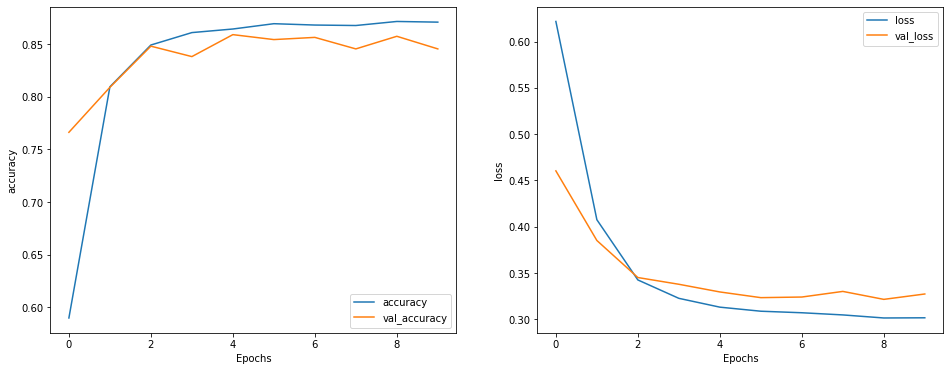

In [42]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')